# Activation Functions

In [ ]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
#sigmoid
def logit(z):
    return 1 / (1 + np.exp(-z))

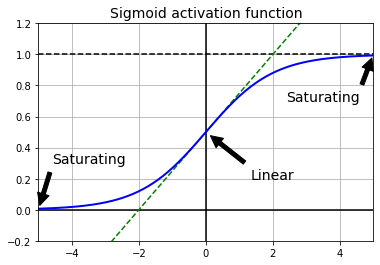

In [ ]:
#sigmoid
z = np.linspace(-5, 5, 200) 

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2]);

In [ ]:
#tanh
def logit(z):
    return ((np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z)))

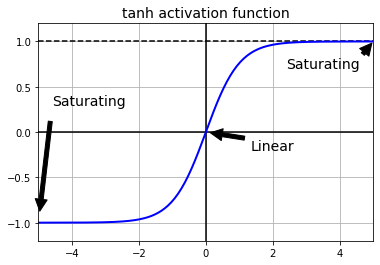

In [ ]:
#tanh
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-1.2, 1.2], 'k-')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, -1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, -0.2), xy=(0, 0), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("tanh activation function", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2]);

## Nonsaturating Activation Functions

### ReLu

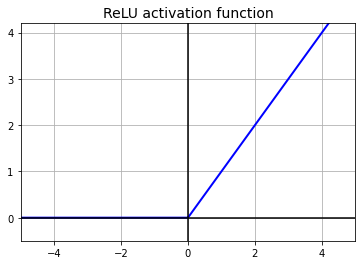

In [ ]:
plt.plot(z, tf.nn.relu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.title("ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2]);

In [ ]:
[m for m in dir(tf.keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

Here's more info

[Activation Functions You Should Know](https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6)

#Linear models, Optimization





We will implement a linear classifier and train it using stochastic gradient descent modifications and numpy.

## Two-dimensional classification

To make things more intuitive, we solve a 2D classification problem with synthetic data.

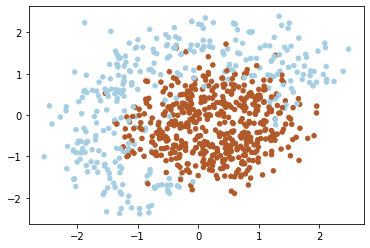

In [ ]:
with open('train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('target.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

# Task

## Features

The data above isn't linearly separable. Because of that we will add features (or use non-linear model). The decision line between two classes are in the form of circles, so we add quadratic features to make the problem linearly separable. 

![](/content/kernel.png)

In [ ]:
def expand(X):
    """This expansion will allow our linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]"""
   
    X_expanded = np.zeros((X.shape[0], 6))
    rows=X.shape[0]
    columns=X_expanded.shape[1]
    
    for j in range(0,columns):
        for i in range(0,rows):
            if j==2:
                X_expanded[i][j]=X_expanded[i][j-2]**2
            elif j==3:
                X_expanded[i][j]=X_expanded[i][j-2]**2
            elif j==4:
                X_expanded[i][j]=X_expanded[i][j-3]*X_expanded[i][j-4]
            elif j==5:
                X_expanded[i][j]=1
            else:
                X_expanded[i][j]=X[i][j]
    return X_expanded

In [ ]:
X_expanded = expand(X)
X_expanded

array([[ 1.20798057,  0.0844994 ,  1.45921706,  0.00714015,  0.10207364,
         1.        ],
       [ 0.76121787,  0.72510869,  0.57945265,  0.52578261,  0.5519657 ,
         1.        ],
       [ 0.55256189,  0.51937292,  0.30532464,  0.26974823,  0.28698568,
         1.        ],
       ...,
       [-1.22224754,  0.45743421,  1.49388906,  0.20924606, -0.55909785,
         1.        ],
       [ 0.43973452, -1.47275142,  0.19336645,  2.16899674, -0.64761963,
         1.        ],
       [ 1.4928118 ,  1.15683375,  2.22848708,  1.33826433,  1.72693508,
         1.        ]])

## Logistic regression

To classify objects we will obtain probability of object belongs to class '1'. To predict probability we will use output of linear model and logistic function:

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [ ]:
def probability(X, w):
    return 1/(1+np.exp(-np.dot(X,w.T)))

In [ ]:
dummy_weights =  np.array([0,0, 0, 0, 0, 1])

prob = probability (X_expanded[:1, :], dummy_weights)[0]

In [ ]:
prob

0.7310585786300049

In logistic regression the optimal parameters $w$ are found by cross-entropy minimization:

Loss for one sample: $$ l(x_i, y_i, w) = - \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1\, | \, x_i,w))}\right] $$

Loss for many samples: $$ L(X, \vec{y}, w) =  {1 \over \ell} \sum_{i=1}^\ell l(x_i, y_i, w) $$



In [ ]:
def compute_loss(X, y, w):

    l = X.shape[0]
    prob = probability(X, w)
    
    return -1/l * np.sum(y * np.log(prob) + (1 - y) * np.log(1 - prob))

In [ ]:
loss = compute_loss(X_expanded, y, dummy_weights)
loss

0.693406965968586

Since we train our model with gradient descent, we should compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \nabla_w l(x_i, y_i, w) $$ 


Here's the formula I'll be using
$$ \frac{ \partial {J }}{\partial {w}} = \frac{1}{l} X.T(prob-y) $$



In [ ]:
def compute_grad(X, y, w):
   
    samples = X.shape[0]
    prob = probability(X,w)
    return (1/samples)*np.dot(X.T,(prob-y))

print(compute_grad(X_expanded,y,dummy_weights))

[-0.16696159  0.15146324  0.39594215  0.39645372  0.17530101  0.11120386]


In [ ]:
grad = np.linalg.norm(compute_grad(X_expanded, y, dummy_weights))
grad

0.6386390002470355

In [ ]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

## Training
In this section we'll use the functions we wrote to train our classifier using stochastic gradient descent.

You can try change hyperparameters like batch size, learning rate and so on to find the best one.

## Stochastic Gradient Descent

It’s a variant of Gradient Descent. It tries to update the model’s parameters more frequently. In this, the model parameters are altered after computation of loss on each training example

## Mini-batch SGD

Stochastic gradient descent just takes a random batch of $m$ samples on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$



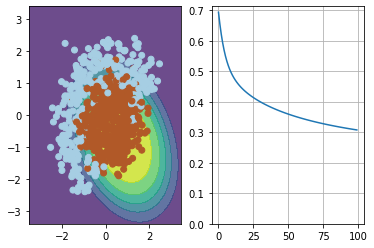

<Figure size 432x288 with 0 Axes>

In [ ]:
np.random.seed(42)


alpha= 0.1 # learning rate
n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, dummy_weights)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], dummy_weights, loss)

    prob=probability(X_expanded,dummy_weights)
    dummy_weights=dummy_weights- alpha*compute_grad(X_expanded,y,dummy_weights)

visualize(X, y, dummy_weights, loss)
plt.clf()


In [ ]:
loss = compute_loss(X_expanded, y, dummy_weights)
loss

0.3069562433893957

In [ ]:
print(dummy_weights)

[ 0.72365337 -0.69500249 -0.65422357 -0.65057183 -0.40023492  1.56909959]


# Other Optimizers Available

In [ ]:
[m for m in dir(tf.keras.optimizers) if not m.startswith("_")]

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'Ftrl',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD',
 'deserialize',
 'get',
 'schedules',
 'serialize']

## Feel free to check-out this article for more information on optimizers

[Types Of Optimizers](https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6)
